In [50]:
import nltk
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt


import os
import requests
import json
import re 

import pickle
from textblob import TextBlob
from sklearn import metrics
from sklearn.preprocessing import minmax_scale
from textblob import Word

#from geopy.geocoders import Nominatim 

# Summary

To get your Factiva pdfs into a machine readable format (.txt) move them into this folder and run the cell under the heading 'Reading In PDF Data'. To get individual files as dataframes, run all cells and then pass the file you want to the factiva_parser function:

my_dataframe = factiva_parser('My_File.txt')

## Very Quick Python Review

### Notebooks

In a Jupyter Notebook, information is contained in vertically stacked 'cells' that can be used to either display text (like this cell) by selecting the Markdown option from the dropdown menu beneath the tabs at the top of the window or perform Python operations by selecting the Code option from the same drop down. A third option designated 'Raw' also allows for the display of text, but without Markdown formatting. Cells can be edited by double clicking within the cells. Cells are executed either by clicking the arrow to the left of the cell dropdown menu used earlier or by using the shortcut 'Ctrl + Enter'

In [2]:
# This cell is rendering code so anything we do not want to be evaluated must be prefaced by a '#' which is referred to as commenting out code.

# Uncommented code is evaluated by the Python interpreter as seen below
2 + 2

4

### Python Data Types and Basic Structures

As we saw above, the python interpreter can take input, perform operations on that input, and return output. There are few limits to the types of operations that can be performed on input, but there are a finite number of ways that input can be represented in Python so we will go over a couple of them here. The most common ways data are represented are int, float, str, and datetime. Any type of data can be stored in a variable which is a name that you give to the data.

In [3]:
print('This is an int: ', 1)
print('This is a float: ', 1.01)
print('This is a string: ', 'Hello')
print('This is a datetime: ', dt.now())

This is an int:  1
This is a float:  1.01
This is a string:  Hello
This is a datetime:  2021-03-23 22:23:19.781668


In [4]:
# We can assign our data to variable names to call upon them later using the '=' operator.

my_integer = 1
my_float = 1.01
my_string = 'Hello'
a_moment_in_time = dt.now()


Note that when the above cell is run, nothing was printed below the cell. This is because we never performed any action in the cell that would return output. We were only assigning names to certain data values. We can reference those names now and the Python interpreter will return the data that the name refers to.

In [5]:
a_moment_in_time

datetime.datetime(2021, 3, 23, 22, 23, 19, 958142)

### Lists, Tuples, and Dictionaries

These data can be arranged into several different types of structures in Python. The most basic is called a list and is created using brackets. This is useful for organizing data that you may want to treat in a unified way in the future. Lists are indexed and items can be added to or removed from the list after its creation (the list is said to be mutable). Tuples are very similar to lists except that they are not mutable and are instantiated using parentheses.

In [6]:
my_list = [my_integer, my_float, my_string, a_moment_in_time]
print(my_list)

my_tuple = (my_integer, my_float, my_string, a_moment_in_time)
print(my_tuple)

my_list[0]

[1, 1.01, 'Hello', datetime.datetime(2021, 3, 23, 22, 23, 19, 958142)]
(1, 1.01, 'Hello', datetime.datetime(2021, 3, 23, 22, 23, 19, 958142))


1

Dictionaries are Pythons implementation of hash tables. Hash tables are data structures that relate named keys to certain values, known as a key-value pair. This is fundamentally different from lists or tuples in that the indexes are no longer positional, but rather indexed by the key. This key can be thought of as similar to a variable name that references the value inside the dictionary. Dictionaries are instantiated using curly brackets with keys and values being related using semicolons.

In [7]:
my_dictionary = {'first_key':1, 'second_key':2, 'you_can_put_whatever_you_want':'for_either_key_or_value'}

print(my_dictionary['first_key'])
print(my_dictionary['you_can_put_whatever_you_want'])

1
for_either_key_or_value


It is worth noting that .json files can be represented in Python as nested dictionaries.

### Pandas and Numpy Arrays

The most common way to handle larger amounts of data inside python is in a pandas dataframe. This can be thought of as pythons version of an Excel table or spreadsheet. It is comprised of columns and rows with the convention being that each column is a variable and each row is an observation. There are many different ways to create dataframes, but the most common is to read in from a csv file using pd.read_csv(). Pandas dataframes are very robust ways to manipulate data but have some important differences from simpler data structures. 

* Columns may contain different data types as in lists or tuples, but this can cause problems when attempting to perform full column calculations
* Pandas dataframes can be indexed by either name or location using the .loc and .iloc methods respectively
* Pandas contains many ways to manipulate the data inside dataframes, which creates overhead. Pandas dataframes will be slightly slower than simpler representations of data, such as lists, or arrays

Numpy arrays are vectorized matrices that allow for increased computational efficiency compared to pandas dataframes. They are MUCH less flexible than pandas dataframes in terms of what operations they allow and are mostly used for more complex mathematics.

In [8]:
my_df = pd.DataFrame({'column1':[1, 2, 3],
                      'column2':['two_types', 'of_data', 1],
                      'descriptive_col_name':['all', 'the', 'strings']})

my_df

,column1,column2,descriptive_col_name
0,1,two_types,all
1,2,of_data,the
2,3,1,strings


### Logic and Control Flow

Python has a number of different operations that allow you to add more complex behavior to your python code. Two of these ways are conditionals and control flow statements. Conditionals evaluate some True-False statement and execute different segments of code depending on the result. Control flow statements allow you rerun a block of code a set number of times. The two most common implementations of conditionals and control flow are 'if-else' statements and for loops resepctively.

In [9]:
x = {'cat':'small', 'elephant':'large','dog':'in-between'}

for i in x:
    if x[i]=='large':
        print('It stays outside')
    else:
        print('Bring it on in')

Bring it on in
It stays outside
Bring it on in


Above we see that the if statement evaluated whether the value associated with key contained the string 'large'. If it evaluated as True, the first output was returned; otherwise the second value was returned. The for loop allowed this evaluation to be performed for every key value in the dictionary x.

## Reading in PDF Data

The following cell reads all available .pdf files in the local directory and converts the well formatted files into .txt files which are more amenable to processing.

In [47]:
#for root, dirs, files in os.walk("."):
#    for filename in files:
#        if filename.endswith('.pdf'):
#            !pdftotext {filename}

from nltk.corpus import stopwords
stop = stopwords.words('english')

## Parsing Factiva Data

Its a good idea to look at the raw text data to make sure it looks similar to the pdf file. Improperly formatted pdf files can be difficult or impossible to convert to machine readable format. Since we are primarily pulling from a single source this shouldn't be a problem but it is important to be aware of the potential issue if using pdf's from other sources. 

In [11]:
f =  open('./JnJ80_84.txt', 'r')  
factiva_raw = f.readlines()
f.close()

factiva_raw[:20]


['Marketing has looked at the succesful PR re-launch of the Johnson and Johnson drug Tylenol. .................................5\n',
 "Johnson and Johnson's Tylenol analgesic capsules have staged a dramatic recovery since seven people in Chicago\n",
 'died after taking Tylenol... ...............................................................................................................................................6\n',
 'Johnson and Johnson has reported net earnings of $150.3m, or 79 cents a share, for the third quarter of 1983. ..........\n',
 '7\n',
 'No Headline ....................................................................................................................................................................8\n',
 'Companies and Markets: Drug problems hit Johnson &Johnson ...................................................................................9\n',
 'JOHNSON & JOHNSON 3RD QTR NET 79C A SHARE VS. OPER. NET 78C ........................................

----------

It looks like we have successfully read in the pdf file into a text file. Notice that when using the readlines method, the output is a list with each line getting it's own entry in the list. The newline character '\n' is also left uninterpreted and included in the output. Both of these observations will be important to recognize during processing.

We now have the data from Factiva in a text file but before we can start to extract information from it we must first convert it to a more organized structure. We will do this by parsing the text using regular expressions. Regular expressions are patterns that allow the user to specify patterns of strings that the regular expression will match. This will allow us to identify useful parts of the text and arrange them accordingly. Regular expressions can be hard interpret due to their concise notation, but a good intro to them and their use can be found at https://docs.python.org/3/library/re.html

We will start by building functions that use regular expressions to extract

In [12]:
def get_titles(factiva_by_lines):
    
    
    # The re expressions used here were created by identifying common patterns present in 
    # the Factiva formatting.
    title_end = re.compile('\.+\d{1,4}\\n')
    new_line = re.compile('\D\\n')
    article_start = re.compile('\d{1,3} words$')
    
    # 
    current = ''
    titles = []
    
    for line in factiva_by_lines:
        
        regex_end = title_end.search(line)
        regex_new = new_line.search(line)
        regex_break = article_start.search(line)
        
        # Detects if the title portion has ended and breaks the loop if so
        if regex_break:
            break
            
        # Handles titles that don't fit on one line
        if regex_new:
            current += line[:regex_new.span()[0]+1]
            continue
        
        if regex_end:
            
            # Strips all the dots from the title using the indices in the regular expression
            title = line[:regex_end.span()[0]]
            current += title
            titles.append(current)
            current = ''
    
    return titles

In [13]:
def get_articles(factiva_by_lines):
    lines = []
    article = ''
    articles = []
    
    article_flag = 0
    
    regex_date = re.compile('^[0-9]?[0-9] (January|February|March|April|May|June|July|August|September|October|November|December) [0-9][0-9][0-9][0-9]$')
    regex_end = re.compile('^Document \S{25}')
    
    for i in factiva_by_lines:
        article_start = regex_date.search(i)
        article_end = regex_end.search(i)
        
        if article_start:
            article_flag = 1
        if article_end:
            articles.append(article)
            article = ''
            article_flag = 0
        if article_flag:
            article += i
    
    
    return articles

In [68]:
len(get_articles(factiva_raw))

98

In [14]:
title = 'Barrons0812_safety_29ove353.pdf'
regex = re.compile("^\D*\d")
match = regex.search(title)
match[0][:-1]

'Barrons'

In [51]:
def get_factiva_title(folder='Eaddy_Factiva'):
    for _, _, files in os.walk('Eaddy_Factiva'):
        for filename in files:
            if filename.endswith('.pdf'):
                print(filename)
        break

def factiva_parser(factiva_txt, stopwords=stop):
    f =  open(factiva_txt, 'r')  
    factiva_raw = f.readlines()
    f.close()
    
    titles = get_titles(factiva_raw)
    articles = get_articles(factiva_raw)
    
    df = pd.DataFrame({'titles':titles, 'articles':articles})
    
    # Preprocessing
    # lowercase
    df['articles'] = df['articles'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    # symbols
    df['articles'] = df['articles'].str.replace('[^\w\s]','', regex=True) 
    # stopwords
    df['articles'] = df['articles'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
    # common Words
    freq = pd.Series(' '.join(df['articles']).split()).value_counts()[:10]
    df['articles'] = df['articles'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    # lemmatization
    df['articles'] = df['articles'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    
    return df

In [52]:
factiva_df = factiva_parser('./JnJ80_84.txt')

In [18]:
factiva_df['articles'] = factiva_df['articles'].apply(lambda x: x.replace('\n', ' '))

In [19]:
factiva_df.iloc[0,1]

"2 December 1983 Marketing MKTG 12 English (c) 1983 Haymarket Business Publications Limited . No part of this data may be reproduced without prior written permission of the owner. A crisis came in Tylenol's sales when the analgesic was contaminated in-store with cyanide causing 7 deaths. To allay public reaction to this disaster, staff volunteers manned a telephone hotline, 150,000 press advertisments were taken out, and 450,000 mailgrams sent. The food and Drugs Administration testified that Johnson was not responsible for the contaminations. A decision was made not to change the name of Tylenol for its relaunch. A tamper resistant pack was designed and the product relaunched on November 11th. Within 12 month's Tylenol's share of the over-the-counter analgesic market has risen from 7% to 28.6%. "

In [20]:
factiva_df.head()

,titles,articles
0,Marketing has looked at the succesful PR re-la...,2 December 1983 Marketing MKTG 12 English (c) ...
1,Johnson and Johnson's Tylenol analgesic capsul...,25 November 1983 Campaign CMPN 8 English (c) 1...
2,Johnson and Johnson has reported net earnings ...,28 October 1983 Financial Times FTFT 25 Englis...
3,Companies and Markets: Drug problems hit Johns...,28 October 1983 The New York Times NYTF Late C...
4,JOHNSON & JOHNSON 3RD QTR NET 79C A SHARE VS. ...,28 October 1983 Financial Times FTFT Page 17 E...


In [21]:
len(factiva_df)

98

Text(0, 0.5, 'Scaling Factor')

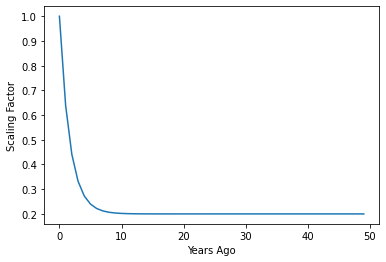

In [22]:
# Corpus Scope vs Article Scope
def fy(x, floor=0.2, shape=.6):
    return ((1/np.exp(x*shape))*(1-floor) + floor)

x = list(range(50))
y = [fy(i) for i in x]
plt.plot(x,y)
plt.xlabel('Years Ago')
plt.ylabel('Scaling Factor')



In [23]:
# calling the Nominatim tool 
#loc = Nominatim(user_agent="GetLoc") 
  
# entering the location name 
#getLoc = loc.geocode("", exactly_one=False) 
  
# printing address 
#print(getLoc) 

### NRC Lexicon

In [24]:
filepath = "./Eaddy_Factiva/NRC-Suite-of-Sentiment-Emotion-Lexicons/NRC-Suite-of-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t')
emolex_df.head(20)

,word,emotion,association
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
5,aback,negative,0
6,aback,positive,0
7,aback,sadness,0
8,aback,surprise,0
9,aback,trust,0


In [31]:
get_valence(factiva_df.iloc[0,1])

-0.03428571428571429

## Salience Factors

In [30]:
def time_decay_fx(x, floor=0.5, shape=0.5):
    return ((1/np.exp(x*shape))*(1-floor) + floor)

def get_valence(article):
    sentiment, subjectivity = TextBlob(article).sentiment
    return sentiment

def get_factiva_date(article):
    regex_date = re.compile('^[0-9]?[0-9] (January|February|March|April|May|June|July|August|September|October|November|December) [0-9][0-9][0-9][0-9]')
    date = regex_date.search(article)
    date = dt.strptime(date[0], '%d %B %Y')
    return date

def get_factiva_proximity(article, time_decay_params):
    
    now = dt.now()
    date = get_factiva_date(article)
    yrs_ago = (now-date).days/365
    time_decay = time_decay_fx(yrs_ago, time_decay_params)
    
    # In the future maybe use machine learning to contextually identify locations. 
    return time_decay
    


def get_crisis_emotions(article,nrc_df=emolex_df):
    # Need to associate negative and positive with the words they correspond to and modify meaning accordingly
    article_dict = {'anger':0,
                    'negative':0,
                    'positive':0,
                    'anticipation':0,
                    'disgust':0,
                    'fear':0,
                    'joy':0,
                    'sadness':0,
                    'surprise':0,
                    'trust':0}
    nrc_words = pd.unique(nrc_df['word'])
    article_words =nltk.word_tokenize(article)
    
    # instead of iterating, make it vectorized for improved performance
    for i in article_words:
        if i in nrc_words:
            subset = nrc_df[nrc_df['word']==i]
            for j in range(subset.shape[0]):
                idx = min(subset.index)
                key = subset.loc[idx+j,'emotion']
                val = subset.loc[idx+j, 'association']
                article_dict[key] += val
    article_dict['total'] = len(article_words)
    return article_dict
            
    
    
# get_crisis_type will difficult as that is obfuscated by fluid subject object relationships when identifying victimhood.
#def get_crisis_type(article):
    #return

In [32]:
get_crisis_emotions(factiva_df.iloc[0,1])

{'anger': 1,
 'negative': 5,
 'positive': 6,
 'anticipation': 2,
 'disgust': 2,
 'fear': 5,
 'joy': 2,
 'sadness': 2,
 'surprise': 1,
 'trust': 4,
 'total': 143}

In [33]:
print((dt.now()- get_factiva_date(factiva_df.iloc[0,1])).days/365)
print(get_factiva_date(factiva_df.iloc[0,1]))
get_factiva_date(factiva_df.iloc[0,1])

37.33424657534247
1983-12-02 00:00:00


datetime.datetime(1983, 12, 2, 0, 0)

In [34]:
factiva_df['Date'] = factiva_df['articles'].apply(get_factiva_date)

In [35]:
factiva_df

,titles,articles,Date
0,Marketing has looked at the succesful PR re-la...,2 December 1983 Marketing MKTG 12 English (c) ...,1983-12-02
1,Johnson and Johnson's Tylenol analgesic capsul...,25 November 1983 Campaign CMPN 8 English (c) 1...,1983-11-25
2,Johnson and Johnson has reported net earnings ...,28 October 1983 Financial Times FTFT 25 Englis...,1983-10-28
3,Companies and Markets: Drug problems hit Johns...,28 October 1983 The New York Times NYTF Late C...,1983-10-28
4,JOHNSON & JOHNSON 3RD QTR NET 79C A SHARE VS. ...,28 October 1983 Financial Times FTFT Page 17 E...,1983-10-28
...,...,...,...
93,TYLENOL COUPONS TO BE MAILED NATIONALLY BEGINN...,18 October 1982 The Wall Street Journal J Engl...,1982-10-18
94,Drug Makers Ask U.S. Rules On Packaging,15 October 1982 The Washington Post WP English...,1982-10-15
95,Suspect in Tylenol Case Once Held in '78 Death,15 October 1982 The New York Times NYTF Late C...,1982-10-15
96,LEGAL BATTLE OVER WHO IS LIABLE FOR THE TYLENO...,14 October 1982 The New York Times NYTF Late C...,1982-10-14


(array([43., 17.,  9.,  9.,  4.,  1.,  0.,  2.,  5.,  8.]),
 array([4669. , 4710.4, 4751.8, 4793.2, 4834.6, 4876. , 4917.4, 4958.8,
        5000.2, 5041.6, 5083. ]),
 <BarContainer object of 10 artists>)

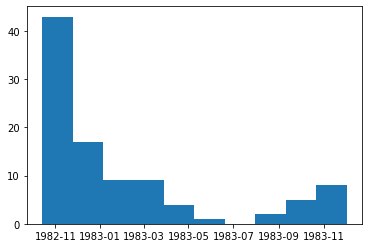

In [36]:
plt.hist(factiva_df['Date'])

In [66]:
for i in range(98):
    print(i, factiva_df.iloc[i,0])

0 Marketing has looked at the succesful PR re-launch of the Johnson and Johnson drug Tylenol. 
1 Johnson and Johnson's Tylenol analgesic capsules have staged a dramatic recovery since seven people in Chicagodied after taking Tylenol... 
2 Johnson and Johnson has reported net earnings of $150.3m, or 79 cents a share, for the third quarter of 1983. ..........No Headline 
3 Companies and Markets: Drug problems hit Johnson &Johnson 
4 JOHNSON & JOHNSON 3RD QTR NET 79C A SHARE VS. OPER. NET 78C 
5 Defense Calls Publicity Goal Of Tylenol Extortion Letters 
6 HEADLINERS 
7 'HUMANIZING' CORPORATIONS 
8 Tylenol Letter Writer Denies Profit Motive 
9 AROUND THE NATION; Arguments Open in Case Of Tylenol Extortion 
10 AROUND THE NATION; Trial Begins for Suspect In Tylenol Extortion 
11 AROUND THE NATION; Co-Tylenol Ruled Out As Cause of Man's Death 
12 Boots pain-relieving drug given approval in US 
13 ADVERTISING; Bristol-Myers Plans Big Coupon Campaign 
14 JOHNSON & JOHNSON UNIT HAVING TROUBLE WI

In [59]:
# Hanks Ranking of every article in the 100 as a test
# done w.r.t. tone and relevance ie a negative article 
# about J&J's competitor is good

hss = minmax_scale([6, 8, 5, 3, 2, 3, 4, 3, 6, 3,
                  2, 2, 4, 7, 6, 4, 6, 5, 3, 4,
                  6, 7, 2, 3, 2, 6, 2, 5, 4, 4,
                  5, 5, 6, 6, 8, 6, 6, 5, 4, 4,
                  6, 6, 7, 8, 7, 9, 8, 7, 4, 3,
                  5, 4, 4, 2, 6, 7, 7, 8, 2, 7,
                  3, 6, 1, 4, 4, 6, 6, 6, 7, 6,
                  4, 3, 4, 2, 6, 3, 3, 3, 6, 2,
                  3, 2, 2, 1, 3, 2, 2, 1, 7, 7,
                  1, 8, 5, 6, 7, 6, 5, 7, 3, 6], (-0.17,0.17))

factiva_df['sent_valence'] = factiva_df['articles'].apply(get_valence, 1)
factiva_df.head()
print(min(factiva_df['sent_valence']))
print(max(factiva_df['sent_valence']))
print(np.mean(factiva_df['sent_valence']))

print('~~~~~~')

print(min(hss))
print(max(hss))
print(np.mean(hss))

metrics.mean_squared_error(hss, factiva_df['sent_valence'])

-0.17261904761904762
0.17142857142857143
0.04374468484220937
~~~~~~
-0.17
0.16999999999999998
-0.013600000000000008


ValueError: Found input variables with inconsistent numbers of samples: [100, 98]

## Twitter API

In addition to pulling data from Factiva or other traditional print media, we may also use data from social media platforms such as Twitter in our analysis.  .In order to use the Twitter API we will need to create a Twitter developer account and get assigned an API key as well as a bearer token. 

In [32]:

def auth():
    return os.environ.get("BEARER_TOKEN")


# Might wanna pass this a dict
def create_url(user_id = 20457806,
               start_time='2009-02-19T19:12:13.000Z', 
               end_time='2018-03-06T00:00:00Z'):
    # Replace with user ID below
    # Start Time limited to 2010-11-06T00:00:00-00:00
    #return "https://api.twitter.com/2/users/{}/tweets?end_time={}".format(user_id, end_time)
    return "https://api.twitter.com/2/users/{}/tweets?end_time={}".format(user_id, end_time)

def user_created_at(user_id = 20457806):
    return 'https://api.twitter.com/2/users/{}'.format(user_id)

def get_params(page=''):
    # Tweet fields are adjustable.
    # Options include:
    # attachments, author_id, context_annotations,
    # conversation_id, created_at, entities, geo, id,
    # in_reply_to_user_id, lang, non_public_metrics, organic_metrics,
    # possibly_sensitive, promoted_metrics, public_metrics, referenced_tweets,
    # source, text, and withheld
    page = page
    if page:
         return {"tweet.fields": "created_at", "pagination_token":page}
    else:
        return {"tweet.fields": "created_at", }


def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers


def connect_to_endpoint(url, headers, params):
    response = requests.request("GET", url, headers=headers, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()


def main(page='', state=[]):
    bearer_token = auth()
    url = create_url()
    headers = create_headers(bearer_token)
    params = get_params(page)
    json_response = connect_to_endpoint(url, headers, params)
    state=state+json_response['data']
    try:
        return main(page=json_response['meta']['next_token'], state=state)
    except KeyError as e:
        print(e)
        return state
    #return json.dumps(json_response, indent=4, sort_keys=True)

def get_acct_age(user_id=20457806):
    bearer_token=auth()
    url='https://api.twitter.com/2/users/{}'.format(user_id)
    headers = create_headers(bearer_token)
    params={'user.fields':'created_at'}
    json_response = connect_to_endpoint(url, headers, params)
    return json_response

In [33]:
x = main()

200
200
'next_token'


In [37]:
# 3236 most recent tweets
recent_tweets = open('recent_tweets.pkl', 'ab') 
      
pickle.dump(x, recent_tweets)                      
recent_tweets.close() 

-----------

In [55]:
objects = []
with (open("recent_tweets.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [56]:
len(objects[0])

3236

In [28]:
created_at = [i['created_at'] for i in objects[0]]
tweet_id = [j['id'] for j in objects[0]]
text = [k['text'] for k in objects[0]]

df = pd.DataFrame({'created_at':created_at,
                 'tweet_id':tweet_id,
                 'text':text})

In [30]:
min(df['created_at'])

'2018-02-21T19:00:06.000Z'

In [ ]:
------------